In [1]:
import os

import tensorflow as tf
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

import cx_Oracle
from sqlalchemy import types, create_engine

os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
tf.set_random_seed(1008)

C:\python\Anaconda3\envs\deeplearning\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Standardization (표준화)
# 요소값 - 평균 / 표준편차
# 평균을 기준으로 얼마나 떨어져 있는가
# 데이터 진폭을 줄어들게 하는 효과
def data_standardization(x):
    x = np.asarray(x)
    return (x - x.mean()) / x.std()

In [3]:
# Normalization (정규화)
# (요소값 - 최소값) / (최대값 - 최소값)
# 전체 구간을 0 ~ 100 으로 설정.
# 너무 작거나 너무 큰 값이 학습을 방해하는 것을 방지하고자 정규화한다
# x가 양수라는 가정하에 최소값과 최대값을 이용하여 0~1사이의 값으로 변환 
# 최대값과 최소값이 같아지는 경우 , /0 문제를 막기 위해 1e-8 을 더함
def Normalization(x):
    x = np.asarray(x)
    return (x - x.min()) / (x.max() - x.min() + 1e-8) # 1e-7은 0으로 나누는 오류 예방차원

In [4]:
# Denormalization (역정규화)
# 요소값 * (원래값의 최대 - 원래값의 최소) + 원래값의 최소
# 전체 구간을 0 ~ 100 으로 설정.
# 너무 작거나 너무 큰 값이 학습을 방해하는 것을 방지하고자 정규화한다
# x가 양수라는 가정하에 최소값과 최대값을 이용하여 0~1사이의 값으로 변환 
# 최대값과 최소값이 같아지는 경우 , /0 문제를 막기 위해 1e-8 을 더함
def Denormalization(denormal_x, normal_x):
    denormal_x = np.asarray(denormal_x)
    normal_x = np.asarray(normal_x)
    return (normal_x * (denormal_x.max() - denormal_x.min() + 1e-8)) + denormal_x.min()

In [5]:
# Oracle DB 에 접속하여 쿼리를 요청하는 함수
def read_query(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute( query )
        names = [ x[0] for x in cursor.description]
        rows = cursor.fetchall()
        return pd.DataFrame( rows, columns=names)
    finally:
        if cursor is not None:
            cursor.close()

In [6]:
# 하이퍼파라미터

# 입력 , 출력 데이터의 컬럼 개수
# 현재가와 거래량을 통해 다음 현재가를 알아볼 것이므로 각각 2 ,1
input_data_count = 2 
output_data_count = 1 

# 시계열데이터 입력 개수
# 과거 30개의 데이터만 알아보기로 함.
timeserial_count = 30            
# lstm에서의 각 셀의 출력 크기
rnn_lstm_hidden= 30

# 망각계수( 망각 편향 )
forget_bias = 1.0
# stacked LSTM layer 개수
num_stacked_layers = 1
# dropout할 때 keep할 비율
# test : 1.0 / train : 0.5 ~ 0.7
keep_prob = 1.0            
# Epoch 회수 (반복 횟수)
max_epoch = 1000
# 학습률
learning_rate = 0.01      

In [7]:
# 데이터의 경로
# 가져올 주식들의 종목을 알아야 하므로 파일 이름만 알아옴.
datapath = os.listdir("../static/data/")
datapath = [i for i in datapath if 'A' in i]
dataname = [i[:7] for i in datapath]
print("datapath : " ,datapath)
print("dataname : " ,dataname)

# oracle DB 에 접속하여 얻어오기.
# 가져온 db에서 키 값인 STOCK_INDEX를 index로 만들기
connect = cx_Oracle.connect("STOCKDJANGO", "dhruddnjs", "localhost/orcl")
targetDataFrame = targetDataFrame = read_query(connect,"select * from %s" % dataname[0])
targetDataFrame = targetDataFrame.set_index("STOCK_INDEX")
targetDataFrame = targetDataFrame.sort_index()
# 시간순으로 정렬되어있으며 시간값은 필요 없으므로 제거
del targetDataFrame['STOCK_DATE'] # 위 줄과 같은 효과
del targetDataFrame['STOCK_TIME'] # 위 줄과 같은 효과
targetDataFrame.head()

datapath :  ['A000100_유한양행.csv', 'A000640_동아쏘시오홀딩스.csv', 'A001630_종근당.csv', 'A006280_녹십자.csv', 'A008930_한미사이언스.csv', 'A009290_광동제약.csv', 'A069620_대웅제약.csv', 'A096760_JW홀딩스.csv', 'A128940_한미약품.csv', 'A249420_일동제약.csv']
dataname :  ['A000100', 'A000640', 'A001630', 'A006280', 'A008930', 'A009290', 'A069620', 'A096760', 'A128940', 'A249420']


,STOCK_PRICE,STOCK_VOLUME
STOCK_INDEX,,
0,219000,206
1,219000,68
2,220000,407
3,219000,317
4,217500,88


In [21]:
# dataframe 형태를 numpy 로 변환하기
# 정규화 하기 위해 사용.
stock = targetDataFrame.values[0:].astype(np.float)
print("stock_info.shape: ", stock.shape)
price = stock[:,:-1]
# 가격형태 데이터 정규화 처리
norm_price = Normalization(price) 
print("price.shape: ", price.shape)
volume = stock[:,-1:]
norm_volume = Normalization(volume)
# 거래량형태 데이터 정규화 처리
print("volume.shape: ", volume.shape)
normal_stock = np.concatenate((norm_price, norm_volume), axis=1)
print("normal_stock.shape: ", normal_stock.shape)
target_stock = normal_stock[:, [0]] # 목표는 주식 현재가
dataX = [] # 입력
dataY = [] # 출력

for i in range(0, len(target_stock) - timeserial_count):
    x = normal_stock[i : i+timeserial_count]
    y = target_stock[i + timeserial_count]
    dataX.append(x) 
    dataY.append(y) 

print(dataX[0])
print(len(dataX[0]))
print(dataY[0])

stock_info.shape:  (76847, 2)
price.shape:  (76847, 1)
volume.shape:  (76847, 1)
normal_stock.shape:  (76847, 2)
[[5.16587678e-01 7.72302592e-03]
 [5.16587678e-01 2.52411091e-03]
 [5.26066351e-01 1.52953586e-02]
 [5.16587678e-01 1.19047619e-02]
 [5.02369668e-01 3.27757685e-03]
 [5.02369668e-01 5.99005425e-03]
 [4.97630332e-01 3.27757685e-03]
 [4.97630332e-01 3.80500301e-03]
 [4.97630332e-01 8.28812538e-03]
 [4.92890995e-01 2.54294756e-02]
 [4.83412322e-01 5.19891501e-03]
 [4.83412322e-01 6.21609403e-03]
 [4.78672986e-01 2.78782399e-03]
 [4.83412322e-01 1.74804099e-02]
 [4.97630332e-01 5.65099458e-04]
 [4.97630332e-01 9.30530440e-03]
 [4.97630332e-01 3.91802291e-03]
 [4.92890995e-01 4.14406269e-04]
 [4.92890995e-01 9.04159132e-04]
 [4.92890995e-01 1.03978300e-02]
 [4.92890995e-01 6.14074744e-03]
 [4.97630332e-01 2.41109102e-03]
 [4.92890995e-01 1.46925859e-03]
 [4.88151659e-01 1.05485232e-03]
 [4.92890995e-01 1.20554551e-03]
 [4.88151659e-01 3.76732972e-04]
 [4.88151659e-01 2.37341772e-

In [15]:
# 학습용/테스트용 데이터 생성 ( 7 : 3)
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size


trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])

testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])

# 텐서플로우에서 사용하기 위한 변수 사용
X = tf.placeholder(tf.float32, [None, timeserial_count, input_data_count], name="input_Data")
print("X: ", X)
Y = tf.placeholder(tf.float32, [None, 1] ,name="output_Data")
print("Y: ", Y)
targets = tf.placeholder(tf.float32, [None, 1] ,name="target")
print("targets: ", targets)
predictions = tf.placeholder(tf.float32, [None, 1],name="predict" )
print("predictions: ", predictions)



X:  Tensor("input_Data:0", shape=(?, 30, 2), dtype=float32)
Y:  Tensor("output_Data:0", shape=(?, 1), dtype=float32)
targets:  Tensor("target:0", shape=(?, 1), dtype=float32)
predictions:  Tensor("predict:0", shape=(?, 1), dtype=float32)


In [16]:
# 모델(LSTM 네트워크) 생성
def lstm_cell():
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=rnn_lstm_hidden, 
                                        forget_bias=forget_bias, state_is_tuple=True, activation=tf.nn.softsign)
    if keep_prob < 1.0:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell

In [17]:
stackedRNNs = [lstm_cell() for _ in range(num_stacked_layers)]
multi_cells = tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_stacked_layers > 1 else lstm_cell()
hypothesis, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)
print("hypothesis: ", hypothesis)
print(_states)

hypothesis:  Tensor("rnn/transpose_1:0", shape=(?, 30, 30), dtype=float32)
LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 30) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 30) dtype=float32>)


In [18]:
# [:, -1]를 잘 살펴보자. LSTM RNN의 마지막 (hidden)출력만을 사용했다.
# 과거 여러 거래일의 주가를 이용해서 다음날의 주가 1개를 예측하기때문에 MANY-TO-ONE형태이다
hypothesis = tf.contrib.layers.fully_connected(hypothesis[:, -1], output_data_count, activation_fn=tf.identity )

In [19]:
# 손실함수로 평균제곱오차를 사용한다
loss = tf.reduce_sum(tf.square(hypothesis - Y))
# 최적화함수로 AdamOptimizer를 사용한다
optimizer = tf.train.AdamOptimizer(learning_rate)
# optimizer = tf.train.RMSPropOptimizer(learning_rate) # LSTM과 궁합 별로임

In [20]:
train = optimizer.minimize(loss)
 
# RMSE(Root Mean Square Error)
# 제곱오차의 평균을 구하고 다시 제곱근을 구하면 평균 오차가 나온다
# rmse = tf.sqrt(tf.reduce_mean(tf.square(targets-predictions))) # 아래 코드와 같다
rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(targets, predictions)))

In [17]:
train_error_summary = [] # 학습용 데이터의 오류를 중간 중간 기록한다
test_error_summary = []  # 테스트용 데이터의 오류를 중간 중간 기록한다
test_predict = ''        # 테스트용데이터로 예측한 결과

sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [18]:
# 학습한다
start_time = datetime.datetime.now() # 시작시간을 기록한다
print('학습을 시작합니다...')
for epoch in range(max_epoch):
    _, _loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
    if ((epoch+1) % 100 == 0) or (epoch == max_epoch-1): # 100번째마다 또는 마지막 epoch인 경우
        
        
        # 학습용데이터로 rmse오차를 구한다
        train_predict = sess.run(hypothesis, feed_dict={X: trainX})
        train_error = sess.run(rmse, feed_dict={targets: trainY, predictions: train_predict})
        train_error_summary.append(train_error)
 
        # 테스트용데이터로 rmse오차를 구한다
        test_predict = sess.run(hypothesis, feed_dict={X: testX})
        test_error = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
        test_error_summary.append(test_error)
        
        # 현재 오류를 출력한다
        print("epoch: {}, train_error(A): {}, test_error(B): {}, B-A: {}".format(epoch+1, train_error, test_error, test_error-train_error))
        
        
end_time = datetime.datetime.now() # 종료시간을 기록한다
elapsed_time = end_time - start_time # 경과시간을 구한다
print('elapsed_time:',elapsed_time)
print('elapsed_time per epoch:',elapsed_time/max_epoch)

학습을 시작합니다...
epoch: 100, train_error(A): 0.006226170342415571, test_error(B): 0.00895534735172987, B-A: 0.0027291770093142986
epoch: 200, train_error(A): 0.00477130152285099, test_error(B): 0.008454910479485989, B-A: 0.0036836089566349983
epoch: 300, train_error(A): 0.004514213185757399, test_error(B): 0.009230082854628563, B-A: 0.004715869668871164
epoch: 400, train_error(A): 0.00444313557818532, test_error(B): 0.009638895280659199, B-A: 0.005195759702473879
epoch: 500, train_error(A): 0.00441445829346776, test_error(B): 0.00964961014688015, B-A: 0.00523515185341239
epoch: 600, train_error(A): 0.004392663482576609, test_error(B): 0.00952958781272173, B-A: 0.005136924330145121
epoch: 700, train_error(A): 0.004373233765363693, test_error(B): 0.009382231160998344, B-A: 0.005008997395634651
epoch: 800, train_error(A): 0.004354985896497965, test_error(B): 0.009233176708221436, B-A: 0.004878190811723471
epoch: 900, train_error(A): 0.004337207414209843, test_error(B): 0.009091700427234173, B

input_data_count: 2,output_data_column_cnt: 1,timeserial_count: 30,rnn_lstm_hidden: 30,forget_bias: 1.0,num_stacked_layers: 1,keep_prob: 1.0,max_epoch: 1000,learning_rate: 0.01,train_error: 0.0043194224,test_error: 0.008961181,min_test_error: 0.0084549105


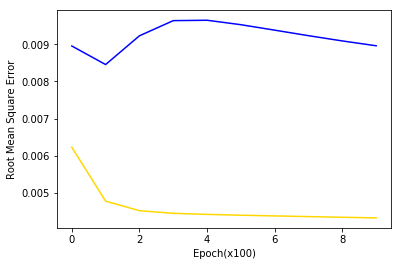

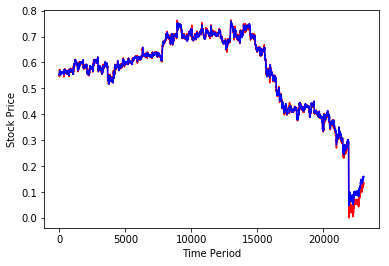

recent_data.shape: (1, 30, 2)
recent_data: [[[0.12796209 0.00685654]
  [0.12796209 0.00391802]
  [0.12796209 0.00625377]
  [0.12796209 0.00546263]
  [0.13270142 0.00636679]
  [0.13270142 0.0050859 ]
  [0.13270142 0.00938065]
  [0.13270142 0.00534961]
  [0.13270142 0.00485986]
  [0.12796209 0.01103828]
  [0.13270142 0.00783605]
  [0.13270142 0.0110006 ]
  [0.13270142 0.00934298]
  [0.13270142 0.01627486]
  [0.13744076 0.03432037]
  [0.13744076 0.00553797]
  [0.13744076 0.00712025]
  [0.13744076 0.00354129]
  [0.13744076 0.00621609]
  [0.13744076 0.00685654]
  [0.13270142 0.0039557 ]
  [0.13744076 0.00632911]
  [0.13744076 0.00572634]
  [0.13270142 0.01879898]
  [0.13744076 0.00655515]
  [0.13270142 0.00316456]
  [0.13270142 0.00470916]
  [0.13744076 0.00369198]
  [0.13744076 0.05172544]
  [0.12796209 0.00388035]]]
test_predict [0.15780616]
Tomorrow's stock price [181148.55]


In [19]:
# 하이퍼파라미터 출력
print('input_data_count:', input_data_count, end='')
print(',output_data_column_cnt:', output_data_count, end='')
 
print(',timeserial_count:', timeserial_count, end='')
print(',rnn_lstm_hidden:', rnn_lstm_hidden, end='')
print(',forget_bias:', forget_bias, end='')
print(',num_stacked_layers:', num_stacked_layers, end='')
print(',keep_prob:', keep_prob, end='')
 
print(',max_epoch:', max_epoch, end='')
print(',learning_rate:', learning_rate, end='')
 
print(',train_error:', train_error_summary[-1], end='')
print(',test_error:', test_error_summary[-1], end='')
print(',min_test_error:', np.min(test_error_summary))
 
# 결과 그래프 출력
plt.figure(1)
plt.plot(train_error_summary, 'gold')
plt.plot(test_error_summary, 'b')
plt.xlabel('Epoch(x100)')
plt.ylabel('Root Mean Square Error')
 
plt.figure(2)
plt.plot(testY, 'r')
plt.plot(test_predict, 'b')
plt.xlabel('Time Period')
plt.ylabel('Stock Price')
plt.show()
 
 
# sequence length만큼의 가장 최근 데이터를 슬라이싱한다
recent_data = np.array([x[len(x)-timeserial_count : ]])
print("recent_data.shape:", recent_data.shape)
print("recent_data:", recent_data)
 
# 내일 종가를 예측해본다
test_predict = sess.run(hypothesis, feed_dict={X: recent_data})
 
print("test_predict", test_predict[0])
test_predict = Denormalization(price,test_predict) # 금액데이터 역정규화한다
print("Tomorrow's stock price", test_predict[0]) # 예측한 주가를 출력한다